# Задание — написать алгоритмы для решения задачи о минимальном остовном дереве и сравнить их работу.

Целью каждой лабораторной работы является реализация, сравнение и анализ двух алгоритмов, решающих одну и ту же задачу. Задание считается выполненным после представления программы, тестов по задаче и беседы по работе. Программа по каждой лабораторной работе должна предусматривать пользовательский ввод данных для небольших значений параметров (тут желательна визуализация входных данных и ответа по задаче), а также предусматривать автоматическую генерацию растущих входных данных и построение графика производительности в зависимости от параметра.

Алгоритм Прима: сначала берётся произвольная вершина и находится ребро, инцидентное данной вершине и обладающее наименьшей стоимостью. Найденное ребро и соединяемые им две вершины образуют дерево. Затем, рассматриваются рёбра графа, один конец которых — уже принадлежащая дереву вершина, а другой — нет; из этих рёбер выбирается ребро наименьшей стоимости. Выбираемое на каждом шаге ребро присоединяется к дереву. Рост дерева происходит до тех пор, пока не будут исчерпаны все вершины исходного графа.

# Настройки/Гиперпараметры/Импорты

In [1]:
import numpy as np # для быстрой работы с массивами
import matplotlib.pyplot as plt # для вывода графиков
import networkx as nx # для построения графов
import random # для случайной генерации графов
import time # для подсчёта времени выполнения
import math # для фибоначчиевой кучи (размер массива при консолидации)

In [2]:
random_state = 42 # для генератора случайных чисел
runs = 3 # число запусков для усреднения времени

## Вспомогательные функции

In [20]:
def print_graph(adj_matrix: np.array, edges=None, circular_layout: bool=True, random_state: int=random_state) -> None:
    """
    функция для построения графа.\n
    Parameters:
        * adj_matrix: матрица смежности
        * edges: рёбра, что надо выделить
        * circular_layout: располагать ли вершины графика как на "круговой" области
        * random_state: случайное число для отображения графа (положение вершин в пространстве; используется если circular_layout=False)\n
    Returns:
        * None (выводит график)
    """

    if adj_matrix.shape[0] > 1000: # проверка на число вершин (если их слишком много, то граф получается неразборчивым)
        print(f"В графе слишком много вершин ({adj_matrix.shape[0]}) для информативного вывода!")
        return # выход из функции

    plt.figure(figsize=(10,10)) # задание размера графика
    
    G = nx.from_numpy_array(adj_matrix) # создаём объект графа из списка смежности
    if circular_layout: # каким образом располагать вершины на графике
        pos = nx.circular_layout(G) # задание позиций вершин графа для графика (на "круговой" области)
    else:
        pos = nx.spring_layout(G, seed=random_state) # случайное задание позиций вершин графа для графика (seed задаёт расположение вершин на графике)

    if edges is not None: # делаем нестандартную окраску рёбер, если они переданы как аргумент
        for edge in edges: # идём по переданным рёбрам (в [edge[0]][edge[1]], [edge[0]] - левая вершина ребра, [edge[1]] - правая вершина ребра)
            G[edge[0]][edge[1]]["color"] = '#1f78b4' # ребро будет синим
            G[edge[0]][edge[1]]["width"] = 3 # ширина ребра (более жирная)

    colors = [] # массив для цветов рёбер
    widths = [] # массив для ширины рёбер
    for edge in G.edges(): # идм по рёбрам
        if "color" in G[edge[0]][edge[1]]: # проверяем, есть ли у них цвет (в [edge[0]][edge[1]], [edge[0]] - левая вершина ребра, [edge[1]] - правая вершина ребра)
            colors.append(G[edge[0]][edge[1]]["color"]) # если есть — добавляем его в массив цветов рёбер
        else: # иначе - цвет ребра будет чёрный
            colors.append("black")

        if "width" in G[edge[0]][edge[1]]: # проверяем, есть ли у них ширина
            widths.append(G[edge[0]][edge[1]]["width"]) # если есть — добавляем её в массив ширины рёбер
        else: # иначе - ширина ребра будет единичной
            widths.append(1)
        
    nx.draw_networkx(G, pos, width=widths, edge_color=colors) # построение графа, pos - позиции вершин графа, width - ширина ребра, edge_color - цвет рёбер
    labels = nx.get_edge_attributes(G, name='weight') # взятие атрибутов рёбер (веса) и запись его в переменную labels (будет идти названием ребёр)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels) # добавление подписей (веса) на рёбра

    plt.show() # вывод графа

In [4]:
def read_adj_matrix(path: str) -> np.array: # функция для ручного ввода (с помощью файла)
    """
    Функция для ручного ввода данных (с помощью файла).\n
    Parameters:
        * path: путь до файла с таблицей смежности\n
    Returns:
        * np.array: таблица смежности
    """
    adj_matrix = []
    with open(path, "r") as f: # открываем файл для чтения
        for line in f: # идём по строкам в файле
            adj_matrix.append([int(x) for x in line.split()]) # добавляем данные в матрицу смежности
    return np.array(adj_matrix) # возвращаем сконвертированную в np.array матрицу смежности 

In [146]:
def generate_graph(nodes_count: int=5, edge_expected: int=10) -> np.array:
    """
    Функция для генерации растущих входных данных.\n
    Parameters:
        * nodes_count: число вершин в создаваемом графе
        * edge_expected: ожидаемое соотношение числа рёбер и вершин в графе (во сколько раз рёбер больше, чем вершин)\n
    Returns:
        * np.array: таблица смежности
    """
    adj_matrix = np.zeros(shape=(nodes_count, nodes_count), dtype=np.uint8) # заготавливаем матрицу смежности (пока заполнена нулями ~ рёбер нет)

    if edge_expected*nodes_count >= nodes_count * (nodes_count-1) / 2: # если ожидаемых рёбер в графе больше, чем може быть — генерируем полносвязный граф (с маловероятным удалением некоторых рёбер) (nodes_count*(nodes_count-1)/2 - максимальное число рёбер в неориентированном графе)
        for i in range(nodes_count-1): # идём по элементам матрицы смежности (кроме последней строки, так как рассматриваем верхнетреугольную матрицу)
            for j in range(i+1, nodes_count): # идём по элементам матрицы смежности (рассматриваем верхнетреугольную матрицу)
                adj_matrix[i][j] = random.randint(0,255) # задаём случайный вес рёбрам от 0 до 255 включительно
                adj_matrix[j][i] = adj_matrix[i][j] # делаем матрицу симметричной
    else: # если есть возможность получить ожидаемое соотношение edge_expected
        # создаём сначала путевой граф для гарантированной связности всех вершин
        for i in np.arange(adj_matrix.shape[0]-1): # идём по рёбрам (рёбра будут из вершины i в i+1) (-1, так как рёбер на 1 меньше, чем вершин в путевом графе)
            adj_matrix[i][i+1] = random.randint(1,255) # задаём этому ребру случайный вес от 1 до 255 (включительно)
            adj_matrix[i+1][i] = adj_matrix[i][i+1] # делаем матрицу симметричной
        edges_count = nodes_count-1 # текущее число рёбер в графе

        #===============вариант с "точным" выбором случайных рёбер, работает очень медленно в больших графах (1000+ вершин)=========================================================================
        # possible_edges = [] # список для возможных рёбер
        # for i in range(nodes_count-1): # идём по элементам матрицы смежности (кроме последней строки, так как рассматриваем верхнетреугольную матрицу)
        #     for j in range(i+1, nodes_count): # идём по элементам матрицы смежности (рассматриваем верхнетреугольную матрицу)
        #         if adj_matrix[i][j] == 0: # если ребра на данный момент в графе нет
        #             possible_edges.append((i,j)) # добавляем его в список возможных
        # edges_to_add = random.sample(possible_edges, nodes_count * edge_expected - edges_count) # случайным образом выбираем рёбра 
        # for edge in edges_to_add: # идём по добавляемым рёбрам    
        #     adj_matrix[edge[0]][edge[1]] = random.randint(1,255) # задаём этому ребру случайный вес от 1 до 255 (включительно)
        #     adj_matrix[edge[1]][edge[0]] = adj_matrix[edge[0]][edge[1]] # делаем матрицу симметричной
        #------------------вариант с рандомизацией, в больших графах (1000+ вершин) работает быстрее, если число ожидаемых рёбер значительно меньше максимального числа рёбер-----------------------       
        # ожидаемое число рёбер в графе nodes_count*edge_expected, в путевом графе уже имеется nodes_count-1 рёбер, следовательно осталось добавить (nodes_count*edge_expected) - (nodes_count-1) = nodes_count*(edge_expected-1)+1
        while edges_count < nodes_count*edge_expected: # пока рёбер в графе меньше, чем мы ожидали
            i = random.randint(0, nodes_count-1) # случайно выбираем первый из концов графа (nodes_count-1 чтобы мы не вышли за рамки массива, так как нумерация идёт с 0, а randint возвращает значение до включительно)
            j = random.randint(0, nodes_count-1) # случайно выбираем второй из концов графа (nodes_count-1 чтобы мы не вышли за рамки массива, так как нумерация идёт с 0, а randint возвращает значение до включительно)
            if i != j and adj_matrix[i][j] == 0: # если выбрали не диагональный элемент и такого ребра ещё не было
                adj_matrix[i][j] = random.randint(1,255) # задаём этому ребру случайный вес от 1 до 255 (включительно)
                adj_matrix[j][i] = adj_matrix[i][j] # делаем матрицу симметричной
                edges_count += 1 # увеличиваем счётчик рёбер
        #=============================================================================================================================================================================================

    return adj_matrix

In [177]:
def get_neighbors(adj_matrix: np.array) -> list:
    """
    Функция для получения соседей вершин в графе.\n
    Parameters:
        * adj_matrix: матрица смежности\n
    Returns:
        * list: список соседей для вершин
    """

    edges = np.argwhere(adj_matrix > 0) # получение всех рёбер с весом > 0 (с дублированием, то есть в писке есть [0,1] и [1,0])

    neighbors = [] # список для окрестностей вершин
    for node in np.arange(adj_matrix.shape[0]): # идём по числу всех вершин и заготавливаем место под их соседей
        neighbors.append([]) # заготавливаем место

    for edge in edges: # идём по рёбрам
        neighbors[edge[0]].append(edge[1]) # добавляем соседей
    return neighbors # возвращает список соседей для вершин

In [207]:
def calc_average_time(func, init_size: int=10, max_size: int=1000, step: int=10, runs: int=3) -> list:
    """
    Функция для подсчёта среднего времени работы алгоритма в зависимости от различного входа.\n
    Parameters:
        * func: функция для оценивания
        * init_size: начальный размер графа
        * max_size: максимальное число вершин в графе
        * step: на сколько вершин увеличивать графы
        * runs: число запусков с одинаковой генерацией для усреднения времени\n
    Returns:
        * list: массив со средним временем
    """
    times = [] # массив для подсчитанного среднего времени
    for nodes_count in range(init_size, max_size+1, step): # рассматриваем графы с числом вершин от init_size до max_size с шагом в step (max_size+1 чтобы захватить max_size в цикле)
        # print(f"generating adj matrix {nodes_count}") # DEBUG
        adj_matrix = generate_graph(nodes_count=nodes_count, edge_expected=10) # генерируем граф, у которого число рёбер в 10 раз больше числа вершин (матрицу смежности)
        # print(f"calculating neighbors {nodes_count}") # DEBUG
        neighbors = get_neighbors(adj_matrix) # получаем список соседей для вершин в графе

        # print(f"running algorithm {nodes_count}") # DEBUG
        time_start = time.perf_counter() # замеряем текущее время
        for i in range(runs): # делаем несколько запусков для усреднения времени
            _ = func(adj_matrix, neighbors) # запускаем алгоритм
        times.append((time.perf_counter() - time_start)/runs) # сохраняем полученное среднее время
    
    return times # возвращаем полученное среднее время


In [216]:
def plot_times(times: list, labels, init_size: int, max_size: int, step: int, colors: list=["b", "r", "g", "y"], title="Время работы алгоритмов в зависимости от числа вершин", xlabel="число вершин в графе", ylabel="время работы алгоритма") -> None:
    """
    Функция для построения графика/ов производительности алгоритма/ов в зависимости от размера данных.\n
    Parameters:
        * times: посчитанные времена выполнения
        * labels: подписи для графиков (если список, а не строка, то times будет восприниматься как список списков времён (времена для каждого алгоритма))
        * init_size: начальный размер данных
        * max_size: максимальное размер данных
        * step: с каким шагом изменялся размер данных
        * title: название графика
        * colors: цвета для графиков
        * xlabel: подпись по оси x
        * ylabel: подпись по оси y\n
    Returns:
        * None: (строит графики производительности)
    """
    x_values = np.arange(init_size, max_size+1, step) # значение по x от init_size до max_size с шагом в step (max_size+1 чтобы захватить max_size)

    plt.figure(figsize=(10,10)) # задание размера графика
    plt.title(title) # название графика
    if isinstance(labels, str): # если labels - одна строка, то выводим один график
        plt.plot(x_values, times, color=colors[0], label=labels) # построение графика времени выполнения алгоритма на метках
    else: # если labels - список, то считаем, что в times времена работы нескольких алгоритмов
        for i in range(len(labels)): # идём по подписям для графиков
            plt.plot(x_values, times[i], color=colors[i], label=labels[i]) # построение графика времени выполнения алгоритма на метках
    plt.xlabel(xlabel) # подпись по оси x
    plt.ylabel(ylabel) # подпись по оси y
    plt.legend() # вывод названий графиков
    plt.show() # вывод графика

# Реализация алгоритмов

## 1) Алгоритм Прима на метках

В синий цвет окрашивается произвольная вершина графа. Далее на каждой итерации для текущего синего дерева вычисляется минимальное допустимое ребро (только один конец которого окрашен в синий). Это ребро и его неокрашенный конец красятся в синий цвет. 

In [194]:
def alg_Prim_with_labels(adj_matrix: np.array, neighbors: list) -> tuple: # на вход — список смежности связного графа (веса рёбер между вершинами, 0 - ребра нет) и список соседей вершин
    """
    Алгоритм Прима с метками, амортизационная сложность — O(n^2).\n
    Parameters:
        * adj_matrix: матрица смежности
        * neighbors: соседи вершин графа\n
    Returns:
        * tuple: (список рёбер минимального остовного дерева, сумма весов этих рёбер)
    """
# подготовка
    nodes_count = adj_matrix.shape[0] # число вершин в графе
    nodes_in_tree = np.full(shape=nodes_count, fill_value=nodes_count) # массив вторых концов рёбер, находящихся в синем дереве, где на i-ой позиции находится номер ближайшей вершины в синем дереве для i, нужен для быстрого добавления рёбер в solution (изначально заполнен недопустимым значением — на 1 больше числа вершин)
    labels = np.zeros(shape=nodes_count) # создаём массив меток (размера числа вершин), пока все вершины считаются неокрашенными (метка - ноль)
    dists = np.full(shape=nodes_count, fill_value=np.inf) # список с минимальными путями (размера числа вершин), где на i-ой позиции длина ребра от вершины i до синего дерева (изначально заполнен inf)

    solution = [] # массив для решения (список рёбер)
    edge_sum = 0 # сумма весов рёбер в остовном дереве (идёт в ответ)

# начальная инициализация — O(n) из-за графа, в котором начальная вершина связана со всеми
    labels[0] = 1 # ставим первой вершине (идёт под индексом 0) метку окрашивания, то есть она теперь одновершинное окрашенное дерево
    for node in neighbors[0]: # идём по вершинам-соседям стартовой вершины
        dists[node] = adj_matrix[0, node] # обновляем их дистанцию до синего дерева
        nodes_in_tree[node] = 0 # обновляем вторые концы рёбер (стартовая вершина для них ближайшая в окрашенном дереве)
    
# добавление рёбер (вершин) в окрашенное синее дерево — O(n^2) из-за n-1 раза поиска вершины с наименьшим расстоянием за O(n) и обновлений для соседей за, в худшем случае, O(n) 
    while (len(solution)) < nodes_count-1: # итерируемся, пока рёбер не будет на 1 меньше, чем вершин в графе (по определению остовного дерева)
        possible_nodes = np.where(labels == 0)[0] # список возможных вершин для добавления (не окрашенных)
        node_to_add = possible_nodes[dists[possible_nodes].argmin()] # ищем ближайшую вершину к синему дереву, что будем добавлять 
        # dists[possible_nodes].argmin() - вернёт позицию вершины с минимальным расстоянием до синего дерева, однако такая позиция может быть смещена, так как мы оставили только те вершины, у которых нет метки окрашивания (possible_nodes)
        # поэтому берём настоящую вершину из possible_nodes по найденному в dists[possible_nodes].argmin() индексу

        labels[node_to_add] = 1 # ставим метку окрашивания выбранной вершине
        solution.append((nodes_in_tree[node_to_add], node_to_add)) # добавляем ребро в решение, где nodes_in_tree[node_to_add] - конец ребра, что уже в синем дереве
        edge_sum += adj_matrix[nodes_in_tree[node_to_add]][node_to_add] # увеличиваем сумму рёбер на вес добавляемого ребра
        
        for node in neighbors[node_to_add]: # идём по вершинам-соседям добавляемой в дерево вершины node_to_add
            if labels[node] == 0: # если соседняя вершина ещё не окрашена
                if adj_matrix[node_to_add, node] < dists[node]: # если расстояние от соседней вершины до дерева уменьшится при добавлении node_to_add в дерево
                    dists[node] = adj_matrix[node_to_add, node] # обновляем расстояние до синего дерева
                    nodes_in_tree[node] = node_to_add # изменяем второй конец ребра в окрашенном дереве

    return solution, edge_sum # возвращаем полученное оптимальное решение (список окрашенных синих рёбер) и его вес

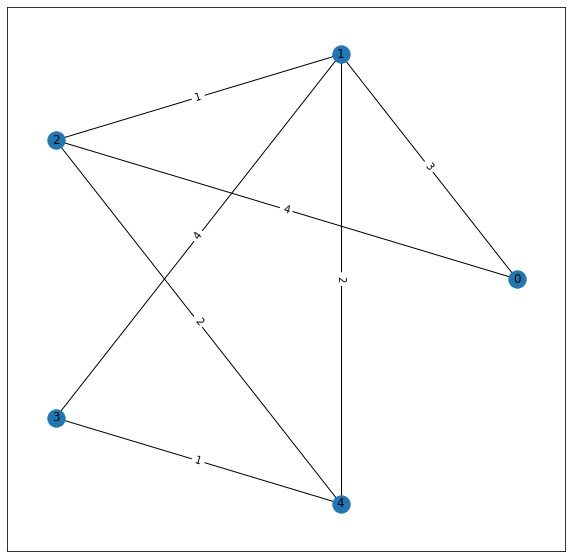

In [195]:
# adj_matrix = np.array([[0, 3, 4, 0, 0], [3, 0, 1, 4, 2], [4, 1, 0, 0, 2], [0, 4, 0, 0, 1], [0, 2, 2, 1, 0]]) # список смежности — веса ребёр (0 - ребра нет)
adj_matrix = read_adj_matrix("data/input1.txt") # считывание матрицы смежности

print_graph(adj_matrix) # вывод начального графа

Сумма весов рёбер в остовном дереве - 7


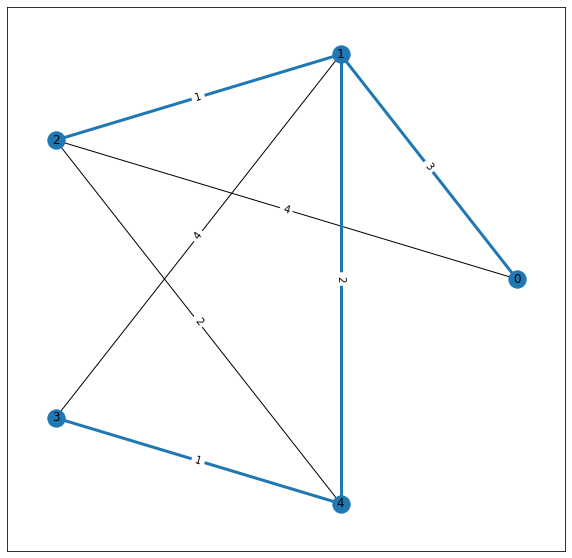

In [196]:
edges_prim_with_labels, edge_sum_prim_with_labels = alg_Prim_with_labels(adj_matrix=adj_matrix, neighbors=get_neighbors(adj_matrix)) # подсчёт остовного дерева алгоритмом Прима с метками
print(f"Сумма весов рёбер в остовном дереве - {edge_sum_prim_with_labels}") # вывод суммы весов рёбер
print_graph(adj_matrix=adj_matrix, edges=edges_prim_with_labels) # вывод остовного дерева

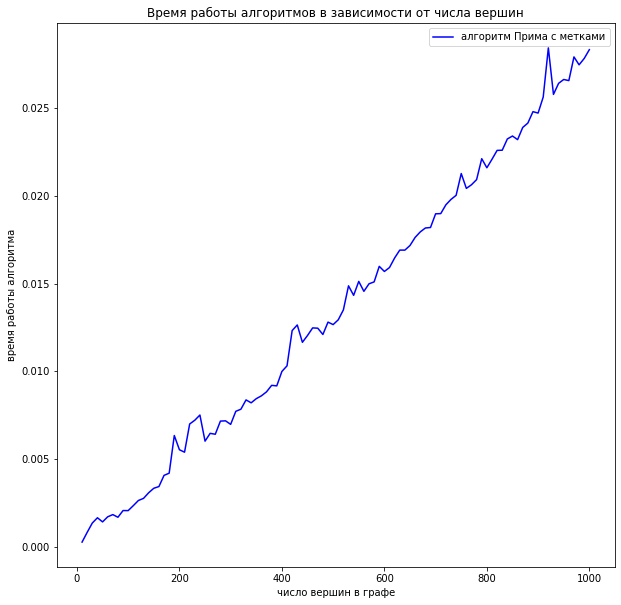

In [201]:
times_prim_with_labels = calc_average_time(func=alg_Prim_with_labels, init_size=10, max_size=1000, step=10, runs=10) # считаем среднее время работы алгоритма Прима с метками для графов размера от 10 до 1000 с шагом в 10 (и усреднением за 10 запусков)
plot_times(times_prim_with_labels, labels='алгоритм Прима с метками', init_size=10, max_size=1000, step=10) # выводим график времени работы алгоритма в зависимости от размера графа

## 2) Алгоритм Прима на Фибоначчиевой куче

Идея: хранить расстояния до синего дерева только для неокрашенных вершин в формате приоритетной очереди (с использованием фибоначчиевой кучи).

In [231]:
class Node:
    """
    Фибоначчиево дерево — биномиальное дерево, в котором у любого узла удаляется не более одного потомка.
    """
    def __init__(self, weight, node_to_add=None, node_in_graph=None): # создание дерева
        self.weight = weight # вес узла (длина ребра до синего дерева)
        # модификация для задачи Прима, чтобы знать номер вершины с минимальным ребром
        self.node_to_add = node_to_add # вершина, которую хотим добавить (что не в синем дереве)
        self.node_in_graph = node_in_graph # вершина, что находится в синем дереве (второй конец ребра)
        # self.in_heap = True # DEBUG

        self.parent = None # родитель
        self.left_bro = None # левый брат
        self.right_bro = None # правый брат
        self.child = None # список детей
        self.degree = 0 # число детей у узла
        self.remove_flag = False # метка, удалялся ли у вершины ребёнок


    def get_edge(self) -> tuple: # возвращаем ребро (node_in_graph, node_to_add)
        return self.node_in_graph, self.node_to_add


    def print_node_information(self): # функция для вывода информации о узле
        print(f"-----------------node information------------------")
        print(f"weight: {self.weight}")
        print(f"node_to_add: {self.node_to_add}")
        print(f"node_in_graph: {self.node_in_graph}")
        print(f"parent: {self.parent.node_to_add if self.parent else self.parent}")
        print(f"left_bro: {self.left_bro.node_to_add if self.left_bro else self.left_bro}")
        print(f"right_bro: {self.right_bro.node_to_add if self.right_bro else self.right_bro}")
        print(f"child: {self.child.node_to_add if self.child else self.child}")
        print(f"degree: {self.degree}")
        print(f"remove_flag: {self.remove_flag}")
        # print(f"in_heap: {self.in_heap}")
    
    
    def change_node_in_graph(self, new_node_ing_graph: int): # функция для обновления номера узла, что находится в синем графе (второго конца ребра)
        self.node_in_graph = new_node_ing_graph # обновляем значение узла в синем графе


class FibonacciHeap:
    """
    Фибоначчиева куча — набор из подвешенных деревьев удовлетворяющих свойству: каждый предок не больше своих детей(если дерево на
    минимум). Это означает, что минимум всей кучи это один из корней этих деревьев. Одним из главных преимуществ Фибоначчиевой кучи
    — гибкость её структуры из-за того, что на деревья не наложены никакие ограничения по форме. Например, Фибоначчиева куча может
    состоять хоть из деревьев в каждом из которых по одному элементу. Такая гибкость позволяет выполнять некоторые операции лениво,
    оставляя работу более поздним операциям.
    """
    def __init__(self): # создание пустой кучи — O(1)
        self.min_node = None # дерево с минимальным корнем
        self.root_list_size = 0 # размер корневого списка (число узлов в корневом списке)
        self.total_nodes = 0 # общее число вершин в куче


    # def print_heap_information(self): # функция для вывода информации о дереве
    #     current_node = self.min_node # текущая вершина
    #     print("*****************")
    #     for i in range(self.root_list_size): # идём по корневому списку
    #         current_node.print_node_information() # выводим информацию о вершине
    #         child = current_node.child # обращаемся к связному списку детей вершины
    #         for i in range(current_node.degree): # идём по детям вершины
    #             print(f"*** child of {current_node.weight}")
    #             child.print_node_information() # выводим информацию о вершине
    #             child = child.right_bro # переходим к следующему ребёнку

    #         current_node = current_node.right_bro # переходим на следующую вершину в корневом списке
    #     print("*****************")


    def get_min(self): # возвращение минимального элемента кучи — O(1)
        return self.min_node
    

    def insert(self, weight, node_to_add: int, node_in_graph: int) -> Node: # добавление узла (одноэлементное дерево Фибоначчи) в кучу — O(1)
        new_node = Node(weight, node_to_add, node_in_graph) # создаём новый узел (одноэлементное дерево Фибоначчи) с передачей его веса (веса ребра от синего дерева до вершины) и соответствующей вершины в графе
        if self.root_list_size == 0: # если в куче нет элементов
            self.min_node = new_node # назначаем добавляемый элемент минимальным
            self.min_node.left_bro = new_node # делаем ссылки на себя же (левый брат)
            self.min_node.right_bro = new_node # делаем ссылки на себя же (правый брат)
        else: # если в куче уже были элементы
            # как бы встраиваем новый узел в двусвязный список правее минимального
            prev_right = self.min_node.right_bro # запоминаем узел предыдущего правого брата минимального элемента (минимальный элемент будет "опорным" для итерации по куче)
            self.min_node.right_bro = new_node # заменяем правого брата у минимальной вершины на новую добавленную
            new_node.left_bro = self.min_node # у добавленного узла левым братом записываем минимальный
            new_node.right_bro = prev_right # у добавленного узла правым братом записываем предыдущего правого брата минимальной вершины
            prev_right.left_bro = new_node # обновляем левого брата (новый узел) прошлой правой вершины (от минимальной)
            if new_node.weight < self.min_node.weight: # если вес у нового добавленного узла меньше, чем был до этого в куче
                self.min_node = new_node # сдвигаем указатель минимального элемента
        self.root_list_size += 1 # увеличиваем размер корневого списка
        self.total_nodes += 1 # увеличиваем общее число вершин в куче Фибоначчи

        return new_node # возвращаем созданный узел (для записи в массив и быстрой работы с узлами по их номеру)


    def union_nodes(self, node1: Node, node2: Node): # объединение двух двусвязных списков (как бы крест-накрест соединили) — O(1)
        prev_node1_left = node1.left_bro # запоминаем левого брата первой вершины
        prev_node2_right = node2.right_bro # запоминаем правого брата второй вершины
        node2.right_bro = node1 # связываем переданные вершины
        node1.left_bro = node2 # связываем переданные вершины
        prev_node1_left.right_bro = prev_node2_right # связываем братьев переданных вершин
        prev_node2_right.left_bro = prev_node1_left # связываем братьев переданных вершин


    def add_child(self, node: Node, child: Node): # добавление child в дети node - O(1)
        # "изолируем" узел (поддерево) child
        child.left_bro.right_bro, child.right_bro.left_bro = child.right_bro, child.left_bro # "отрываем" child из двусвязного списка (на него теперь в двусвязном спике никто не указывает)
        child.left_bro, child.right_bro = child, child # его левый и правый браться — он сам (у узла-ребёнка остаются только ссылки на себя)

        if node.child is None: # если детей до этого у вершины node не было
            node.child = child # назначаем вершину ребёнком
        else: # если дети были — объединяем
            self.union_nodes(node.child, child) # объединяем списки
        child.parent = node # задаём родителя узлу-ребёнку
    

    # не используется
    # def merge_heaps(self, second_heap): # объединение двух куч (вызывается от первой кучи с передачей второй как аргумента) — O(1)
    #     if second_heap.root_list_size == 0: # если вторая куча пустая, то просто выходим
    #         return
    #     if self.root_list_size == 0: # если первая куча пустая, а вторая нет — просто присваиваем первой куче те же значения, что во второй (дублируем)
    #         self.min_node = second_heap.min_node 
    #         self.root_list_size = second_heap.root_list_size
    #     else: # если обе кучи не пустые
    #         self.union_nodes(self.min_node, second_heap.min_node) # объединяем двусвязные корневые списки у куч
    #         self.root_list_size += second_heap.root_list_size # увеличиваем размер корневого списка
    #         if self.min_node.weight < second_heap.min_node.weight: # если у второй кучи был элемент с меньшим весом
    #             self.min_node = second_heap.min_node # делаем ссылку на него в первой куче


    def consolidate(self): # консолидация преобразует кучу таким образом, что в корневом списке остается не более degree(Heap)+1 вершин (объединение деревьев с одинаковой степенью ~ числом детей у корня, что-то типа Round-Robin процедуры для биномиальных деревьев) — O(logn)
        # до консолидации в корневом списке было не более degree(Heap)+t(H)-1 деревьев, где degree(Heap) - максимальное число поддеревьев после удаления минимального узла, t(H)-1 - размер корневого списка после удаления минимального узла и без включения его поддеревьев)
        # а станет не более degree(Heap)+1 деревьев(корней)

        A = np.full(int(math.log(self.total_nodes, 2) + 3), None) # создаём массив для записи "объединений" деревьев
        self.min_node.parent = None # обнуляем родителя, так как min_node — уже корень дерева (нужно из-за вызова consolidate с детьми минимальной вершины, чтобы убрать у них ссылку на родителя)
        A[self.min_node.degree] = self.min_node # записываем минимальный (на данный момент он не настоящий минимальный) элемент в массив

        current_node = self.min_node.right_bro # идём по вершинам, начиная с правой от "минимальной", саму "минимальную" мы уже добавили в массив

        for i in range(self.root_list_size-1): # идём по числу узлов в корневом списке (-1, так как минимальную вершину уже добавили)
            current_node.parent = None # обнуляем родителя для элементов из корневого списка (так как они и есть корни своих деревьев) (нужно из-за вызова consolidate с детьми минимальной вершины, чтобы убрать у них ссылку на родителя)
            next_node = current_node.right_bro # запоминаем следующую вершину, если эту придётся объединить

            while A[current_node.degree] is not None: # пока не нашли пустую ячейку
                # если в массиве на позиции degree уже есть дерево, то объединяем их и пытаемся записать на позицию degree+1
                node_in_A = A[current_node.degree] # берём уже записанный узел, чтобы потом его объединить с current_node
                if node_in_A.weight <= current_node.weight: # определяем, какое дерево к какому присоединять — присоединяем к тому, у которого вес меньше (<= на случай с одинаковыми весами, чтобы минимум был всегда в корне дерева)
                    node_in_A, current_node = current_node, node_in_A # "меняем местами" узлы на текущей итерации

                self.add_child(current_node, node_in_A) # добавляем к детям current_node поддерево из node_in_A

                A[current_node.degree] = None # очищаем ячейку, с деревом из которой было объединение (ещё не инкрементировали степень вершины)
                current_node.degree += 1 # увеличиваем степень узла, к которому было проведено присоединение (и пытаемся записать в следующую ячейку)
                self.root_list_size -= 1 # уменьшаем размер корневого списка, так как при объединении стало на 1 дерево меньше 

            A[current_node.degree] = current_node # положим в пустую ячейку текущий элемент

            if current_node.weight <= self.min_node.weight: # обновляем минимальный узел, если нужно (<= на случай с одинаковыми весами, чтобы минимум был всегда в корне дерева)
                self.min_node = current_node

            current_node = next_node # переходим к следующему узлу


    def extract_min(self) -> Node: # удаление минимального элемента кучи — O(logn) из-за консолидации
        node_with_min_weight = self.min_node # запоминаем текущий минимальный по весу узел

        if node_with_min_weight.child: # если у минимального узла есть дети (параметр не None)
            self.union_nodes(node_with_min_weight, node_with_min_weight.child) # объединяем корневой список и детей минимальной вершины (размер корневого списка становится degree(min_node)+root_list_size)
            # что становится с указателем на родителя??? как-нибудь перетрётся при консолидации
            self.root_list_size += self.min_node.degree # обновляем размер корневого списка

        # "изолируем" узел (но не поддерево) min_node
        node_with_min_weight.left_bro.right_bro, node_with_min_weight.right_bro.left_bro = node_with_min_weight.right_bro, node_with_min_weight.left_bro # "отрываем" min_node из двусвязного списка (на него теперь в двусвязном спике никто не указывает, однако он пока указывает на своих старых соседей)
        self.root_list_size -= 1 # уменьшаем размер корневого списка на 1 (удалённый минимальный элемент)
        self.total_nodes -= 1 # уменьшаем число всех вершин в куче

        if node_with_min_weight.right_bro == node_with_min_weight: # если в корневом списке оказался лишь один узел (одноэлементная Фибоначчиева куча)
            self.min_node = None # зануляем указатель на минимальный элемент
        else: # иначе — "объединяем" фибоначчиевы деревья (пропуская минимальный узел)
            self.min_node = self.min_node.right_bro # пока что перекинем указатель min на правого брата, а далее consolidate() скорректирует min в процессе выполнения
            self.consolidate() # вызываем консолидацию

        # node_with_min_weight.in_heap = False # DEBUG
        # node_with_min_weight.parent = None # DEBUG
        # node_with_min_weight.left_bro = None # DEBUG
        # node_with_min_weight.right_bro = None # DEBUG
        return node_with_min_weight # возвращаем минимальный узел
    

    def cut(self, node: Node): # вырезание вершины — O(1)
        # "изолируем" узел 
        node.left_bro.right_bro, node.right_bro.left_bro = node.right_bro, node.left_bro # "отрываем" node из двусвязного списка (на него теперь в двусвязном спике никто не указывает)
        node.parent.degree -= 1 # уменьшаем степень вершины родителя

        if node.parent.child == node: # если узел node - связь родителя с детьми
            if node.right_bro == node: # если у родительской вершины был всего один ребёнок
                node.parent.child = None # теперь у вершины-родителя нет детей
            else: # иначе — смещаем ссылку на соседнего ребёнка
                node.parent.child = node.right_bro
        
        node.right_bro, node.left_bro = node, node # удаляем ссылки на братьев у node
        node.parent = None # удаляем ссылку на родителя у вершины
        self.union_nodes(self.min_node, node) # добавляем узел (с поддеревом) в корневой список
        self.root_list_size += 1 # увеличиваем размер корневого списка


    def cascade_cut(self, node: Node): # рекурсивная функция вырезания родителей — O(1), амортизационная
        # Если у вершины до этого не удаляли дочерний узел (node.remove_flag=False), то мы помечаем эту вершину (node.remove_flag=True) и прекращаем выполнение операции. 
        # В противном случае применяем операцию cut для текущей вершины и запускаем каскадное вырезание от родителя.
        while node.remove_flag: # вырезаем, пока у родителей есть метка, что уже одно ребёнка у них вырезали (и пока узлом node не стал None ~ в случае, когда дошли до корня, из которого уже что-то вырезалось)
            parent = node.parent # запоминаем родителя для следующей итерации (так как в cut он превращается в None)
            if parent: # вырезаем только если у вершины есть родитель (если она уже не находится в корневом списке)
                self.cut(node) # вырезаем узел
                node = parent # переходим к следующему родителю
            else: # если родителя нет — выходим из цикла
                break
        if node: # проверка, что мы не перешли на parent узла из корневого списка (для узлов в корневом списке parent — None)
            node.remove_flag = True # помечаем последнюю вершину, что у неё удалялся узел-ребёнок


    def decrease_weight(self, node: Node, new_weight): # уменьшение веса элемента (ребра от синего дерева до вершины node.node_in_graph) — O(1), амортизационная
        # было бы хорошо, чтобы вершина не всплывала до корня, и тогда дерево не придется сильно перестраивать
        # для этого при удобном случае будем вырезать поддерево полностью и перемещать его в корневой список

        # изменение веса в сторону увеличения, видимо, не рассматривается
        node.weight = new_weight # просто обновляем вес e epkf
        if node.parent and new_weight < node.parent.weight: # если новый вес нарушил свойство кучи (вес узла должен быть не меньше веса родителя)
            parent = node.parent # запоминаем родителя
            self.cut(node) # вырезаем вершину
            self.cascade_cut(parent) # каскадно вырезаем родителей
            
        if new_weight < self.min_node.weight: # обновляем указатель на минимальный элемент, если потребуется
            self.min_node = node


    def DEBUG(self, node: Node): # удаление вершины — O(logn) из-за удаления минимального элемента
        # удаление вершины реализуется через уменьшение ее веса до -inf и последующим извлечением минимума
        self.decrease_weight(node, np.inf) # уменьшаем вес вершины на inf
        self.extract_min() # удаляем минимальную вершину

In [232]:
def alg_Prim_with_Fibonacci_heap(adj_matrix: np.array, neighbors: list) -> tuple: # на вход — список смежности связного графа (веса рёбер между вершинами, 0 - ребра нет) и список соседей вершин
    """
    Алгоритм Прима с Фибоначчиевой кучей, амортизационная сложность — O(nlogn).\n
    Parameters:
        * adj_matrix - матрица смежности
        * neighbors - соседи вершин графа\n
    Returns:
        * tuple: (список рёбер минимального остовного дерева, сумма весов этих рёбер)
    """

# подготовка
    nodes_count = adj_matrix.shape[0] # число вершин в графе
    nodes = np.full(shape=nodes_count, fill_value=None) # массив вершин в фибоначчиевой куче (размера числа вершин), суть примерна та же, что в предыдущем алгориитме у labels и dists (изначально заполнен None)
    
    heap = FibonacciHeap() # куча с путями до синего дерева
    
    solution = [] # массив для решения (список рёбер)
    edge_sum = 0 # сумма весов рёбер в остовном дереве (идёт в ответ)

# начальная инициализация — O(n) из-за графа, в котором начальная вершина связана со всеми
    nodes[0] = heap.insert(0, 0, 0) # добавляем в кучу вершину с дистанией до синего дерева 0 под номером 0 и ближайшей вершиной в синем дереве 0
    for node in neighbors[0]: # идём по вершинам-соседям стартовой вершины
        nodes[node] = heap.insert(adj_matrix[0, node], node, 0) # обновляем кучу (добавляем в неё узел с длиной ребра, номером добавляемой вершины, номером вершины в синем графе) 
        # и записываем созданную Node в массив nodes для быстрого обращения (последующего изменения её веса/ближайшей вершины в синем графе)

    _ = heap.extract_min() # удаляем нулевую (стартовую - 0,0,0) вершину из дерева

# добавление рёбер (вершин) в окрашенное синее дерево — O(n * (logn + 1)) ~ O(nlogn + n) ~ O(nlogn) так как n раз будет взятие минимума за O(logn) и обновление весов за O(1) по амортизационной оценке
    # iteration = 0 # DEBUG
    while (len(solution)) < nodes_count-1: # итерируемся, пока рёбер не будет на 1 меньше, чем вершин в графе (по определению остовного дерева)
        # iteration += 1 # DEBUG
        # print(f"\n***iteration: {iteration}***") # DEBUG
        # print(f"minimum: {heap.min_node.node_to_add}") # DEBUG
        # for i, n in enumerate(nodes): # DEBUG
        #     if n is not None: # DEBUG
        #         n.print_node_information() # DEBUG
        #     else: # DEBUG
        #         print(f"node {i} is None") # DEBUG
        # print(f"-------------------------------------------------") # DEBUG

        edge_to_add = heap.extract_min().get_edge() # получаем из кучи оптимальное ребро вида (вершина в синем дереве, добавляемая вершина)
        # print(f"adding node {edge_to_add[1]}") # DEBUG

        solution.append(edge_to_add) # добавляем ребро в решение
        edge_sum += adj_matrix[edge_to_add[0]][edge_to_add[1]] # увеличиваем сумму рёбер на вес добавляемого ребра

        nodes[edge_to_add[1]].weight = 0 # так как вершина теперь в синем дереве, то дистанция от неё до синего дерева равна нулю (вершина уже не в куче, поэтому обновление веса без вызова decrease_weight)
        for node in neighbors[edge_to_add[1]]: # идём по вершинам-соседям добавляемой в дерево вершины
            if nodes[node] is None: # если в кучу ещё нет узла, отвечающего за вершину графа node
                nodes[node] = heap.insert(adj_matrix[edge_to_add[1], node], node, edge_to_add[1]) # добавляем этот узел
                # print(f"neighbor {node} created") # DEBUG
            else: # если в куче уже есть узел, отвечающий за вершину
                if adj_matrix[edge_to_add[1], node] < nodes[node].weight: # проверяем, уменьшится ли расстояние для этого узла до синего дерева при добавлении вершины edge_to_add[1] в дерево
                    # print(f"updating neighbor {node} weight") # DEBUG
                    # print(f"nodes before update:") # DEBUG
                    # print(f"minimum: {heap.min_node.node_to_add}") # DEBUG
                    # for i, n in enumerate(nodes): # DEBUG
                    #     if n is not None: # DEBUG
                    #         n.print_node_information() # DEBUG
                    #     else: # DEBUG
                    #         print(f"node {i} is None") # DEBUG
                    # print(f"-------------------------------------------------") # DEBUG

                    heap.decrease_weight(nodes[node], adj_matrix[edge_to_add[1], node]) # обновляем вес вершины nodes[node] на значение adj_matrix[edge_to_add[1], node], где edge_to_add[1] - новая добавленная вершина в синее дерево (с каскадным вырезанием) 
                    nodes[node].change_node_in_graph(edge_to_add[1]) # обновляем ближайшую веришну в синем дереве
                #     print(f"neighbor {node} weight updated") # DEBUG
                #     print(f"nodes after update:") # DEBUG
                #     for i, n in enumerate(nodes): # DEBUG
                #         if n is not None: # DEBUG
                #             n.print_node_information() # DEBUG
                #         else: # DEBUG
                #             print(f"node {i} is None") # DEBUG
                #     print(f"-------------------------------------------------") # DEBUG
                # else:
                #     print(f"neighbor {node} skipped due to weight") # DEBUG

    return solution, edge_sum # возвращаем полученное оптимальное решение (список окрашенных синих рёбер) и его вес

Сумма весов рёбер в остовном дереве - 7


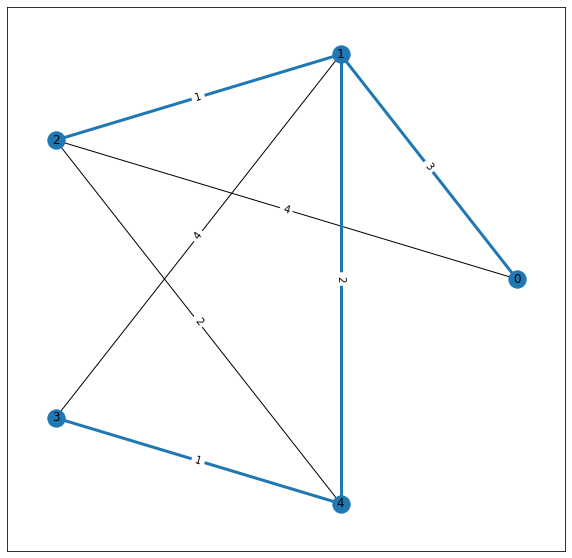

In [204]:
edges_prim_with_fib_heap, edge_sum_prim_with_fib_heap = alg_Prim_with_Fibonacci_heap(adj_matrix=adj_matrix, neighbors=get_neighbors(adj_matrix)) # подсчёт остовного дерева алгоритмом Прима с Фибоначчиевой кучей
print(f"Сумма весов рёбер в остовном дереве - {edge_sum_prim_with_fib_heap}") # вывод суммы весов рёбер
print_graph(adj_matrix=adj_matrix, edges=edges_prim_with_fib_heap) # вывод остовного дерева

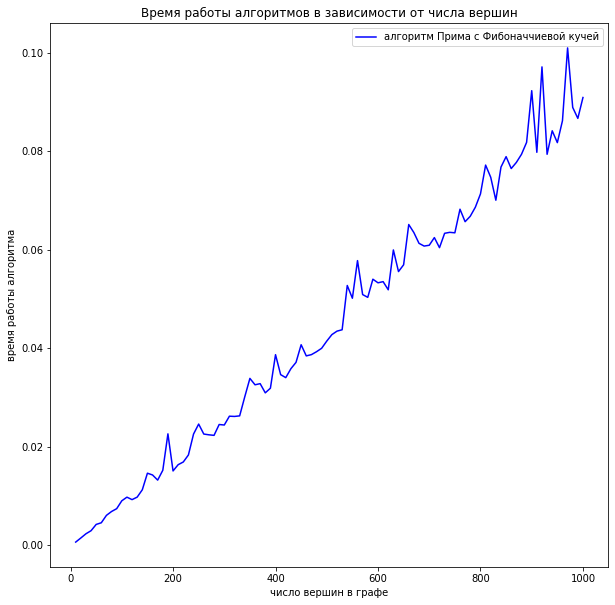

In [234]:
times_prim_with_fib_heap = calc_average_time(func=alg_Prim_with_Fibonacci_heap, init_size=10, max_size=1000, step=10, runs=10) # считаем среднее время работы алгоритма Прима с метками для графов размера от 10 до 1000 с шагом в 10 (и усреднением за 10 запусков)
plot_times(times_prim_with_fib_heap, labels='алгоритм Прима с Фибоначчиевой кучей', init_size=10, max_size=1000, step=10) # выводим график времени работы алгоритма в зависимости от размера графа

**Ответы у алгоритмов получились одинаковые и оптимальные, что свидетельствует о корректности их работы.**

# Сравнение алгоритмов

In [235]:
def performance_measurement(init_size: int=10, max_size: int=1000, step: int=10, runs: int=3) -> None:
    """
    Функция для построения графика производительности.\n
    Parameters:
        * init_size: начальный размер графа
        * max_size: максимальное число вершин в графе
        * step: на сколько вершин увеличивать графы
        * runs: число запусков с одинаковой генерацией для усреднения времени\n
    Returns:
        * None: (строит графики производительности)
    """
    times = [[], []] # список для сохранения времени
    for nodes_count in np.arange(init_size, max_size+1, step): # рассматриваем графы с числом вершин от init_size до max_size с шагом в step (max_size+1 чтобы захватить max_size в цикле)
        # print(f"generating adj matrix {nodes_count}") # DEBUG
        adj_matrix = generate_graph(nodes_count=nodes_count, edge_expected=10) # генерируем граф, у которого число рёбер в 10 раз больше числа вершин (матрицу смежности)
        # print(f"calculating neighbors {nodes_count}") # DEBUG
        neighbors = get_neighbors(adj_matrix) # получаем список соседей для вершин в графе

        # print(f"running algorithm labels {nodes_count}") # DEBUG
        # считаем среднее время для алгоритма Прима с метками
        time_start = time.perf_counter() # замеряем текущее время
        for i in range(runs): # делаем несколько запусков для усреднения времени
            res_alg_Prim_with_labels = alg_Prim_with_labels(adj_matrix, neighbors) # запускаем алгоритм
        times[0].append((time.perf_counter() - time_start)/runs) # сохраняем полученное среднее время с метками

        # print(f"running algorithm heap {nodes_count}") # DEBUG
        # аналогично для алгоритма Прима с Фибоначчиевой кучей
        time_start = time.perf_counter() # замеряем текущее время
        for i in range(runs): # делаем несколько запусков для усреднения времени
            res_alg_Prim_with_Fib_heap = alg_Prim_with_Fibonacci_heap(adj_matrix, neighbors) # запускаем алгоритм
        times[1].append((time.perf_counter() - time_start)/runs) # сохраняем полученное среднее время с Фибоначчиевой кучей

        if res_alg_Prim_with_labels[1] != res_alg_Prim_with_Fib_heap[1]: # проверка, что ответы получились одинаковые по весу рёбер
            raise Exception(f"Ответы алгоритмов разные! У меток — {res_alg_Prim_with_labels[1]}, у Фибоначчиевой кучи — {res_alg_Prim_with_Fib_heap[1]}") # выкидываем исключение
    
    plot_times(times=times, labels=["алгоритм Прима с метками", "алгоритм Прима с Фибоначчиевой кучей"], init_size=init_size, max_size=max_size, step=step) # выводим графики времени


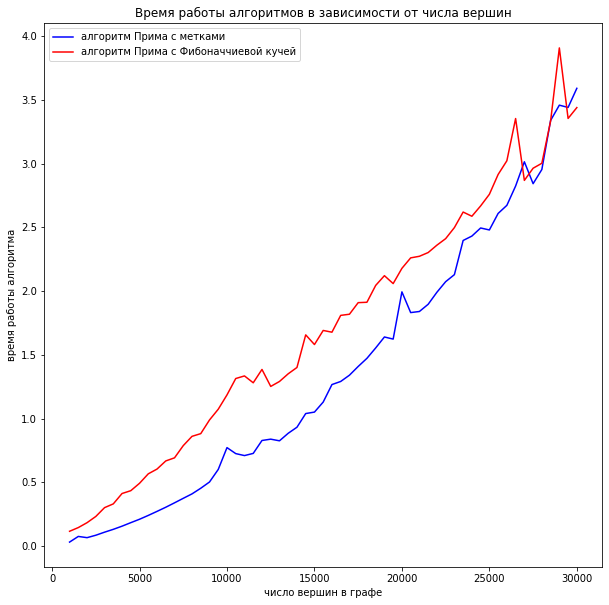

In [236]:
performance_measurement(init_size=1000, max_size=30000, step=500, runs=5)

Алгоритм Прима с метками получился чуть более быстрым на рассматриваемом множестве вершин. Однако, можно заметить, что рост времени у алгоритма с метками идёт стремительнее, из-за чего при большем числе вершин уже вариант с Фибоначчиевой кучей окажется быстрейшим.